In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pathlib import Path
from module.data import create_test_loader
from module.masks import extract_bc_rim_from_y, make_rim_mask_like, make_smooth_phi
from module.model import TC_AFNO_Intensity
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [2]:
data_path = "/N/slate/kmluong/PROJECT2/level_2_data/wrf_tropical_cyclone_track_5_dataset_X.npy"
x = np.load(data_path)
x.shape


(2731, 5, 100, 100, 11)

In [3]:
test_loader = create_test_loader(
    np_path=data_path,
    train_frac=0.7,
    val_frac=0.2,
    step_in=3,
    batch_size=8,
    num_workers=0,
    pin_memory=True,
)
X_test_np = test_loader.dataset.X
num_times = X_test_np.shape[1]
num_vars = X_test_np.shape[2]
H = X_test_np.shape[3]
W = X_test_np.shape[4]
x_mean = torch.zeros(num_vars)
x_std = torch.ones(num_vars)
y_mean = torch.zeros(num_vars)
y_std = torch.ones(num_vars)
model = TC_AFNO_Intensity(
    num_vars=num_vars,
    num_times=num_times,
    H=H,
    W=W,
    num_blocks=4,
    film_zdim=64,
    x_mean=x_mean,
    x_std=x_std,
    y_mean=y_mean,
    y_std=y_std,
    return_physical=False,
).to(device)
RIM = 3
phi = make_smooth_phi(H=H, W=W, rim=RIM, device=device, dtype=torch.float32)


In [4]:
checkpoint_path = Path("/N/slate/kmluong/PROJECT2/checkpoints/best_model.pt")
if checkpoint_path.exists():
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
else:
    print(f"Checkpoint not found: {checkpoint_path}")
model.eval()


TC_AFNO_Intensity(
  (stem): Conv2d(45, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bc_encoder): BCEncoder(
    (net): Sequential(
      (0): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): GELU(approximate='none')
      (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): GELU(approximate='none')
      (4): AdaptiveAvgPool2d(output_size=1)
    )
    (proj): Linear(in_features=64, out_features=64, bias=True)
  )
  (blocks): ModuleList(
    (0-3): 4 x CondAFNO2DBlock(
      (block): AFNO2DBlock(
        (linear1): Linear(in_features=128, out_features=128, bias=True)
        (linear2): Linear(in_features=128, out_features=128, bias=True)
        (mlp): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
          (1): GELU(approximate='none')
          (2): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
        )
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
     

In [5]:
def plot_test_sample(model, loader, sample_id, channel, device):
    """
    Visualize a single test sample with BC-conditioned prediction.
    """
    model.eval()
    dataset = loader.dataset
    sample = dataset[sample_id]
    x = sample["fields"].unsqueeze(0).to(device)
    y_true = sample["target_fields"].unsqueeze(0).to(device)
    x_vis = x
    if model.x_scaler is not None:
        x = model.x_scaler.norm(x)
    y_true_norm = y_true
    if model.y_scaler is not None:
        y_true_norm = model.y_scaler.norm(y_true)
    B_fill = extract_bc_rim_from_y(y_true_norm, rim=RIM)
    bc_mask = make_rim_mask_like(y_true_norm, rim=RIM)
    bc_in = torch.cat([B_fill, bc_mask], dim=1)
    with torch.no_grad():
        y_free = model(x, bc_in)
        y_pred = phi * y_free + (1.0 - phi) * B_fill
    if model.y_scaler is not None:
        y_pred = model.y_scaler.denorm(y_pred)
    inputs = x_vis[0, :, channel].cpu()
    real = y_true[0, channel].cpu()
    pred = y_pred[0, channel].cpu()
    diff = torch.abs(real - pred)
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes[0, 0].imshow(inputs[0])
    axes[0, 0].set_title("Input step 1")
    axes[0, 1].imshow(inputs[1])
    axes[0, 1].set_title("Input step 2")
    axes[0, 2].imshow(inputs[2])
    axes[0, 2].set_title("Input step 3")
    axes[1, 0].imshow(real)
    axes[1, 0].set_title("Ground Truth")
    axes[1, 1].imshow(pred)
    axes[1, 1].set_title("Prediction")
    axes[1, 2].imshow(diff)
    axes[1, 2].set_title("|Real - Prediction|")
    for ax in axes.flatten():
        ax.axis("off")
    plt.tight_layout()
    plt.show()


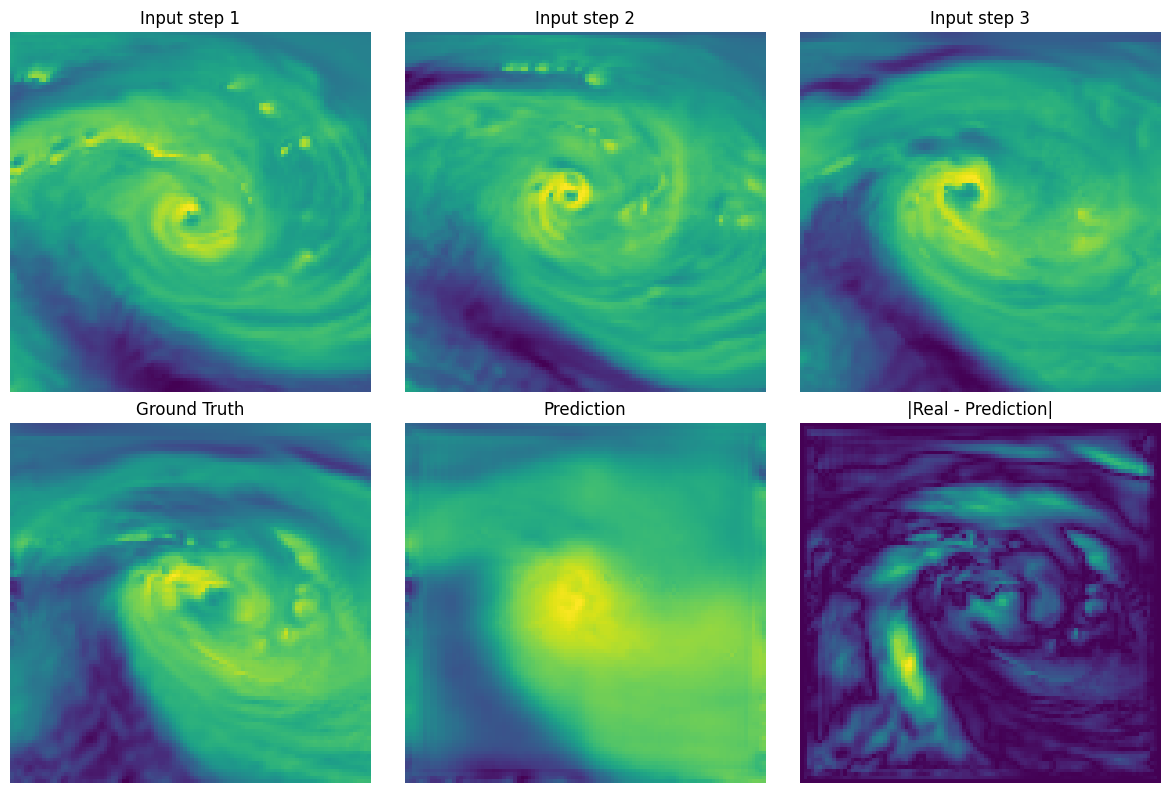

In [6]:
plot_test_sample(
    model=model,
    loader=test_loader,
    sample_id=5,
    channel=9,
    device=device,
)
